In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import zipfile
# from natsort import natsorted
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
# from model import VAE

import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchmetrics
from dataloader.animal_faces import AnimalfaceDataset


In [3]:
# Load dataset
device = torch.device("cuda")
cpu_device = torch.device("cpu")

In [66]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [89]:
train_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((128,128)), AddGaussianNoise(0, 0.05)])

In [90]:
train_data = AnimalfaceDataset(transform=transform)

100%|█████████████████████████████████████████████████████████████████████████| 14630/14630 [01:33<00:00, 156.95it/s]


In [105]:
val_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((128,128))])
val_data = AnimalfaceDataset(transform=transform, type="val")

100%|███████████████████████████████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 167.68it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 3, 128, 128]) torch.Size([512])


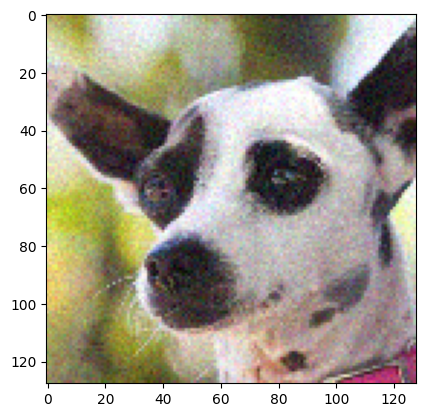

In [95]:
BATCH_SIZE = 512
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
x, y = next(iter(val_loader))
print(x.shape, y.shape)
show_img(x)

In [96]:
from models.auto_encoder import AutoEncoder, Encoder, Decoder
%reload_ext autoreload
%autoreload 2

In [97]:
# conv_ip_size = (128, 6, 6)
# feature_size = 2048 
# filters = [3,12,24,48,128]
# kernel_sizes = [7, 5, 3, 3]
# strides = [2, 2, 2, 2]
# output_paddings = [1,0,0,1]
# paddings = [0,0,0,0]


feature_size = 2048 
filters = [3, 16, 32]
kernel_sizes = [7,5]
strides = [2,2]
output_paddings = [0,1]
paddings = [0,0]
return_only_liner = 1
feature_size = 2048
dropout_prob = 0.05
if return_only_liner:
    conv_ip_size = (3, 128, 128)
    hidden_sizes = [128*128*3, 8192, feature_size]
else:
    conv_ip_size = (32, 29, 29)
    hidden_sizes = [conv_ip_size[0]*conv_ip_size[1]*conv_ip_size[2], 8192, 4096, feature_size]

In [98]:
e = Encoder(enc_op_size=feature_size, conv_op_size=conv_ip_size, filters=filters, 
            kernel_sizes=kernel_sizes,strides=strides, hiddens_sizes=hidden_sizes, 
            return_only_liner=return_only_liner, return_only_conv=0)
op = e(x)
op.shape
summary(e, (3,128,128), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1                [-1, 49152]               0
            Linear-2                 [-1, 8192]     402,661,376
              ReLU-3                 [-1, 8192]               0
           Dropout-4                 [-1, 8192]               0
            Linear-5                 [-1, 2048]      16,779,264
Total params: 419,440,640
Trainable params: 419,440,640
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 0.58
Params size (MB): 1600.04
Estimated Total Size (MB): 1600.80
----------------------------------------------------------------


In [51]:
d = Decoder(dec_ip_size=feature_size, conv_op_size=conv_ip_size, filters=filters[::-1], 
                               kernel_sizes=kernel_sizes[::-1],strides=strides[::-1], output_paddings=output_paddings,
                                 paddings=paddings, hiddens_sizes=hidden_sizes[::-1] , return_only_liner=return_only_liner)
do = d(op)
do.shape
summary(d, (2048,), device="cpu")

[2048, 8192, 49152]
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1                 [-1, 2048]               0
            Linear-2                 [-1, 8192]      16,785,408
              ReLU-3                 [-1, 8192]               0
           Dropout-4                 [-1, 8192]               0
            Linear-5                [-1, 49152]     402,702,336
         Unflatten-6          [-1, 3, 128, 128]               0
Total params: 419,487,744
Trainable params: 419,487,744
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.95
Params size (MB): 1600.22
Estimated Total Size (MB): 1601.18
----------------------------------------------------------------


In [99]:
ae = AutoEncoder(feature_size=feature_size, conv_ip_size=conv_ip_size, filters=filters, 
                 kernel_sizes=kernel_sizes,strides=strides,output_paddings=output_paddings, 
                 paddings=paddings, hiddens_sizes=hidden_sizes, return_only_liner=return_only_liner, droput_prob=dropout_prob).to(device)
op, enc = ae(x.to(device))
print(op.shape, enc.shape)

summary(ae, (3,128,128), device="cuda")

[2048, 8192, 49152]
torch.Size([512, 3, 128, 128]) torch.Size([512, 2048])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1                [-1, 49152]               0
            Linear-2                 [-1, 8192]     402,661,376
              ReLU-3                 [-1, 8192]               0
           Dropout-4                 [-1, 8192]               0
            Linear-5                 [-1, 2048]      16,779,264
           Encoder-6                 [-1, 2048]               0
           Dropout-7                 [-1, 2048]               0
            Linear-8                 [-1, 8192]      16,785,408
              ReLU-9                 [-1, 8192]               0
          Dropout-10                 [-1, 8192]               0
           Linear-11                [-1, 49152]     402,702,336
        Unflatten-12          [-1, 3, 128, 128]               0
          Decoder-13        

In [100]:
show_img = lambda x: plt.imshow(x.permute(0,2,3,1).detach().to(cpu_device).numpy()[0])

In [101]:
%%time
n_epochs = 100
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(ae.parameters(), lr=0.0001)
# losses = []
# val_losses = []
for epoch in range(n_epochs):
    ae.train()
    tqdm_obj = tqdm(train_loader)
    for i, (X,y) in enumerate(tqdm_obj):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        
        X_hat, enc = ae(X) # [B, feature_size]
        loss = loss_fn(X, X_hat)
        loss.backward()
        optim.step()

        tqdm_obj.set_description_str(f"Epoch: {epoch} Loss {loss}")
        if i%1 == 0:
            losses.append(loss.detach().to(cpu_device))
    
    with torch.no_grad(): # mandatory to write
        ae.eval()
        tqdm_obj = tqdm(val_loader)
        for i, (X,y) in enumerate(tqdm_obj):
            X, y = X.to(device), y.to(device)

            X_hat, enc = ae(X) # [B, feature_size]
            val_loss = loss_fn(X, X_hat)

            tqdm_obj.set_description_str(f"Epoch {epoch} Val Loss {val_loss}")
            if i%1 == 0:
                val_losses.append(val_loss.detach().to(cpu_device))
                

Epoch: 34 Loss 0.02293127030134201: 100%|████████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


Epoch 68 Val Loss 0.01909453421831131: 100%|███████████████████████████████████████████| 3/3 [00:00<00:00,  5.05it/s]


Epoch 99 Val Loss 0.017765134572982788: 100%|██████████████████████████████████████████| 3/3 [00:00<00:00,  5.11it/s]

CPU times: user 6h 21min 8s, sys: 3min 29s, total: 6h 24min 37s
Wall time: 27min 58s


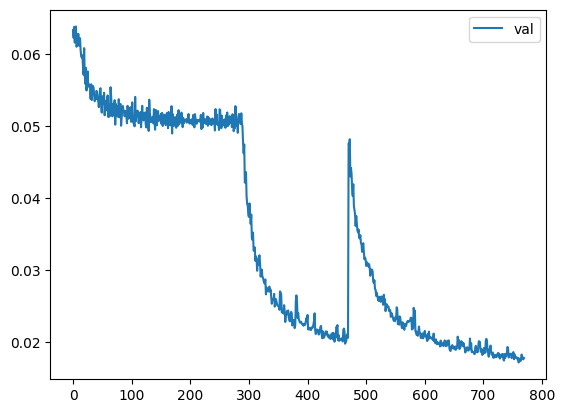

In [102]:
to_cpu = lambda arr: [each.detach().to(cpu_device) for each in arr]
# plt.plot(to_cpu(losses), label="train")
plt.plot(to_cpu(val_losses)[10:], label="val")
plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


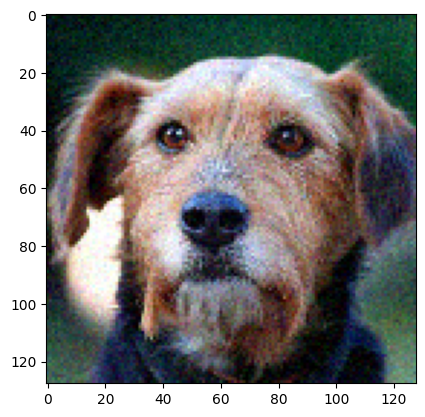

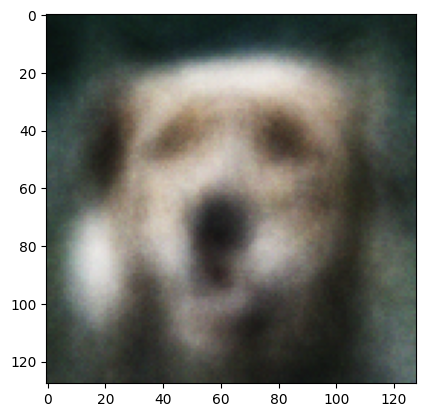

In [109]:
x, y = next(iter(val_loader))
with torch.no_grad():
    ae.eval()
    x_hat, enc = ae(x.to(device))
plt.figure()
show_img(x)
plt.figure()
show_img(x_hat)

### Observations
Effect of kernels size: 
Keep all constant (3)

effect of latent dim:
Try: 2048, 128X6X6

effect of number of filters: Looks like val loss decreasing if we increase number of filters

In [119]:
feature_size

2048

In [110]:
torch.save(ae.state_dict(), f"ckpts/autoencoder_{feature_size}_3l_gauss.pt")